# Import necessary libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
import joblib
from flask import Flask, request, jsonify

# Load the datasets

In [34]:
train_df = pd.read_csv('input/exploring-predictive-health-factors/train.csv')
test_df = pd.read_csv('input/exploring-predictive-health-factors/test.csv')
cleaned_df = pd.read_csv('input/diet-exercise-and-pcos-insights/Cleaned-Data.csv')

# Display basic info about the dataset

In [35]:
print("Train Dataset Info:")
train_df.info()
print("\nTest Dataset Info:")
test_df.info()
print("\nCleaned Dataset Info:")
cleaned_df.info()

Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     210 non-null    int64  
 1   Age                    209 non-null    object 
 2   Weight_kg              208 non-null    float64
 3   PCOS                   210 non-null    object 
 4   Hormonal_Imbalance     208 non-null    object 
 5   Hyperandrogenism       207 non-null    object 
 6   Hirsutism              205 non-null    object 
 7   Conception_Difficulty  209 non-null    object 
 8   Insulin_Resistance     209 non-null    object 
 9   Exercise_Frequency     208 non-null    object 
 10  Exercise_Type          208 non-null    object 
 11  Exercise_Duration      208 non-null    object 
 12  Sleep_Hours            208 non-null    object 
 13  Exercise_Benefit       209 non-null    object 
dtypes: float64(1), int64(1), object(12)
me

# Check the column names to confirm the target column name

In [36]:
print("Columns in train_df:")
print(train_df.columns)

Columns in train_df:
Index(['ID', 'Age', 'Weight_kg', 'PCOS', 'Hormonal_Imbalance',
       'Hyperandrogenism', 'Hirsutism', 'Conception_Difficulty',
       'Insulin_Resistance', 'Exercise_Frequency', 'Exercise_Type',
       'Exercise_Duration', 'Sleep_Hours', 'Exercise_Benefit'],
      dtype='object')


# Handle missing values by imputation

# For train, test and cleaned datasets: filling missing numerical values with mean and categorical with most frequent value

# For numeric columns, impute using mean

In [37]:
numeric_cols_train = train_df.select_dtypes(include=[np.number]).columns
train_df[numeric_cols_train] = train_df[numeric_cols_train].fillna(train_df[numeric_cols_train].mean())

# Repeat for test and cleaned datasets

In [38]:
numeric_cols_test = test_df.select_dtypes(include=[np.number]).columns
test_df[numeric_cols_test] = test_df[numeric_cols_test].fillna(test_df[numeric_cols_test].mean())

numeric_cols_cleaned = cleaned_df.select_dtypes(include=[np.number]).columns
cleaned_df[numeric_cols_cleaned] = cleaned_df[numeric_cols_cleaned].fillna(cleaned_df[numeric_cols_cleaned].mean())

# For categorical columns, impute using the most frequent value

In [39]:
categorical_cols_train = train_df.select_dtypes(include=['object', 'category']).columns
train_df[categorical_cols_train] = train_df[categorical_cols_train].fillna(
    train_df[categorical_cols_train].mode().iloc[0])

train_df['PCOS'] = train_df['PCOS'].map({'Yes': 1, 'No': 0})

# Repeat for test and cleaned datasets

In [40]:
categorical_cols_test = test_df.select_dtypes(include=['object', 'category']).columns
test_df[categorical_cols_test] = test_df[categorical_cols_test].fillna(test_df[categorical_cols_test].mode().iloc[0])

categorical_cols_cleaned = cleaned_df.select_dtypes(include=['object', 'category']).columns
cleaned_df[categorical_cols_cleaned] = cleaned_df[categorical_cols_cleaned].fillna(
    cleaned_df[categorical_cols_cleaned].mode().iloc[0])

# Check for missing values after imputation

In [41]:
print("\nMissing Values in Train Data after Imputation:")
print(train_df.isnull().sum())

print("\nMissing Values in Test Data after Imputation:")
print(test_df.isnull().sum())

print("\nMissing Values in Cleaned Data after Imputation:")
print(cleaned_df.isnull().sum())


Missing Values in Train Data after Imputation:
ID                       0
Age                      0
Weight_kg                0
PCOS                     0
Hormonal_Imbalance       0
Hyperandrogenism         0
Hirsutism                0
Conception_Difficulty    0
Insulin_Resistance       0
Exercise_Frequency       0
Exercise_Type            0
Exercise_Duration        0
Sleep_Hours              0
Exercise_Benefit         0
dtype: int64

Missing Values in Test Data after Imputation:
ID                       0
Age                      0
Weight_kg                0
Hormonal_Imbalance       0
Hyperandrogenism         0
Hirsutism                0
Conception_Difficulty    0
Insulin_Resistance       0
Exercise_Frequency       0
Exercise_Type            0
Exercise_Duration        0
Sleep_Hours              0
Exercise_Benefit         0
dtype: int64

Missing Values in Cleaned Data after Imputation:
Age                           0
Weight_kg                     0
Height_ft                     0
Mari

# Visualize missing values

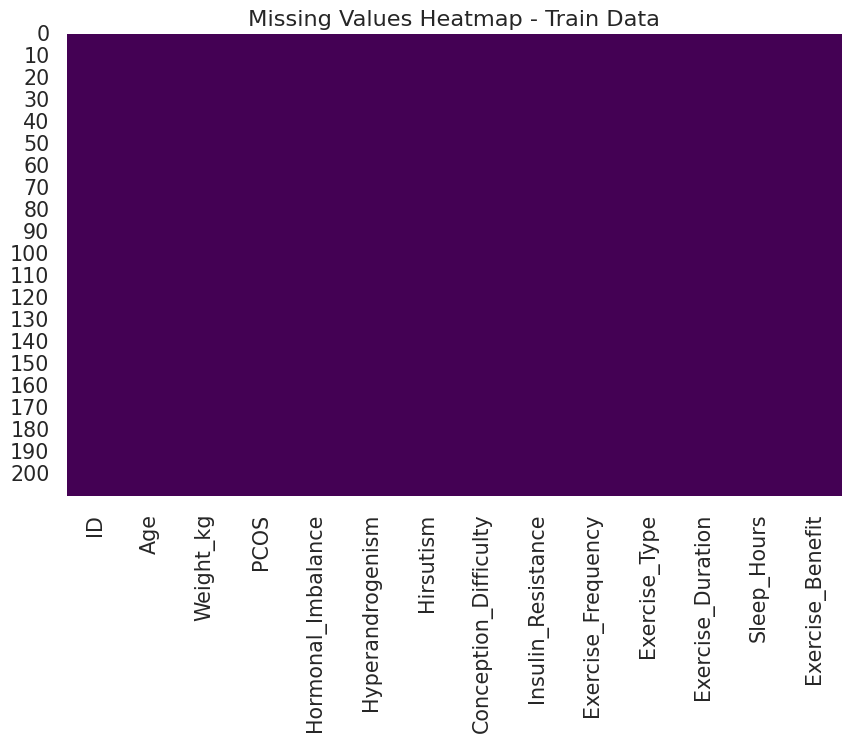

In [42]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap - Train Data')
plt.show()

# Visualize the distribution of numerical columns

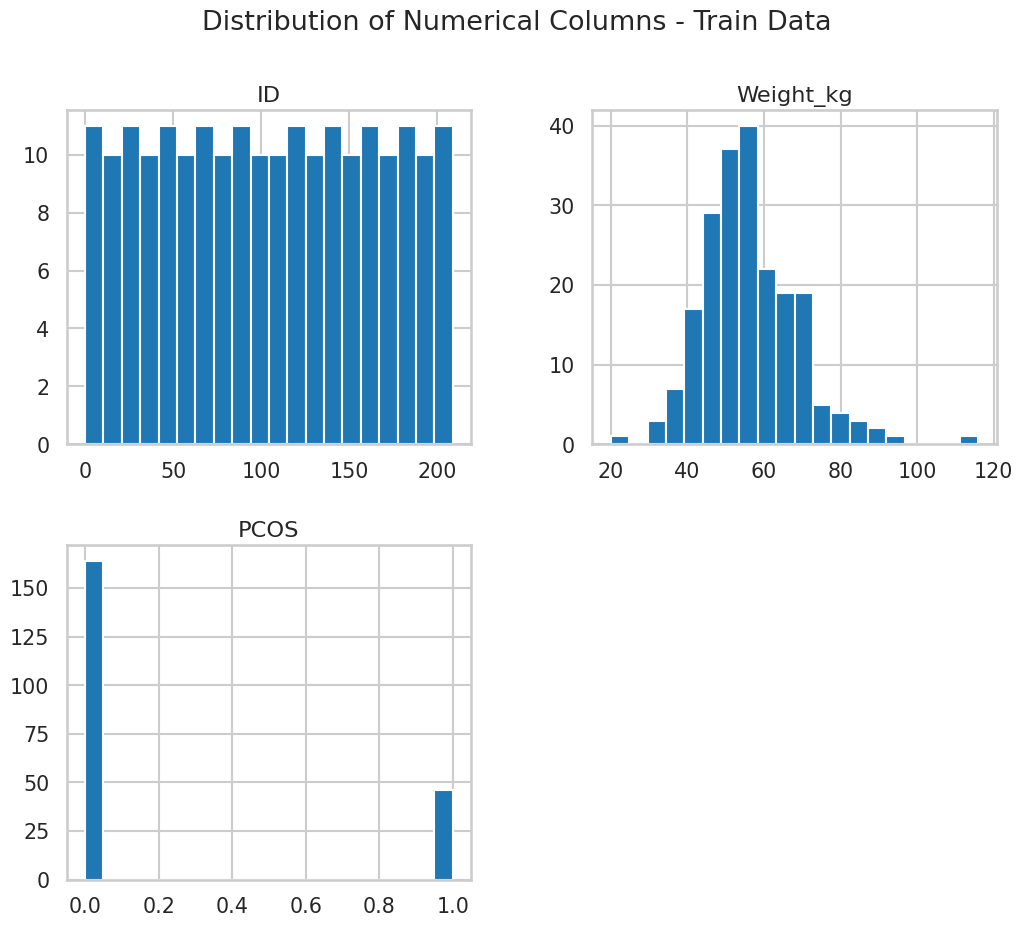

In [43]:
numerical_cols = train_df.select_dtypes(include=[np.number]).columns
train_df[numerical_cols].hist(figsize=(12, 10), bins=20)
plt.suptitle('Distribution of Numerical Columns - Train Data')
plt.show()

# Correlation heatmap

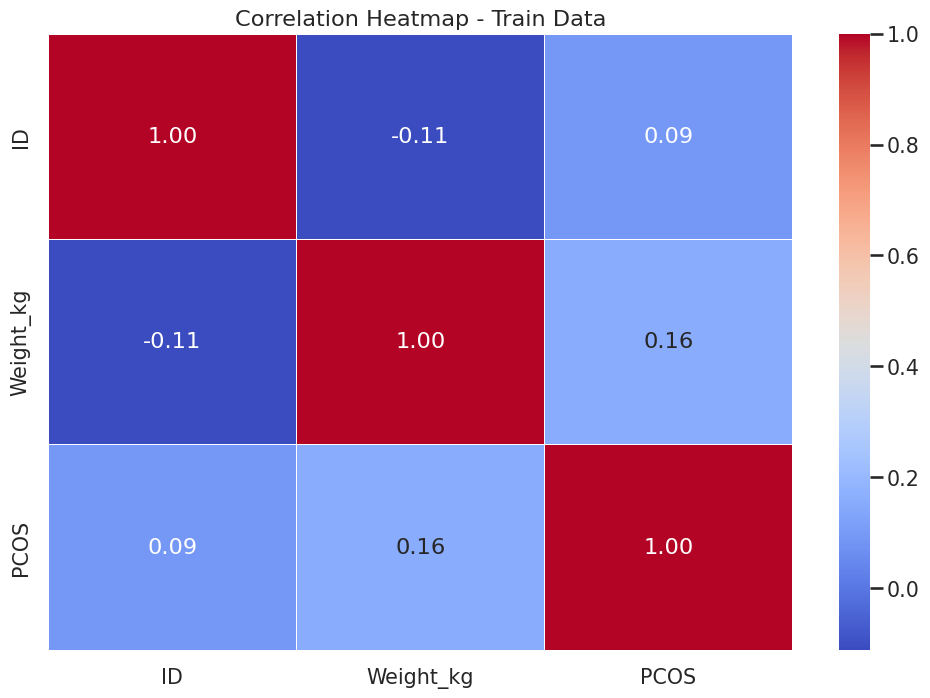

In [44]:
correlation_matrix = train_df[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap - Train Data')
plt.show()

# Box plots to detect outliers

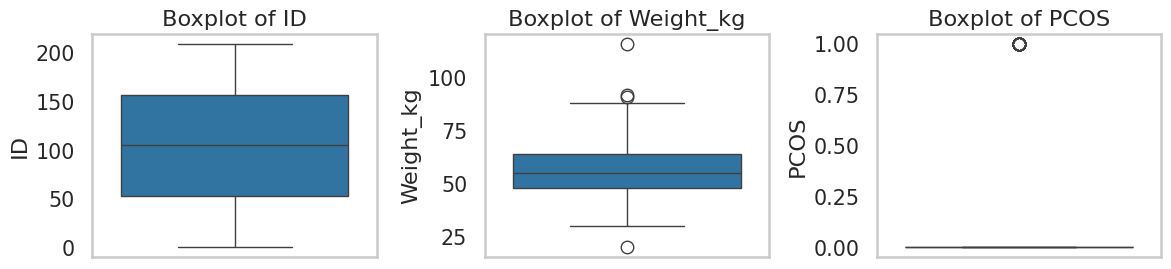

In [45]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)  # Adjust for the number of numerical columns
    sns.boxplot(train_df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Visualize categorical columns if any

# Set style for clean aesthetics

In [46]:
sns.set_style("whitegrid", {"axes.grid": False})
sns.set_context("talk", font_scale=0.9)
plt.rcParams["font.family"] = "DejaVu Sans"  # Use a clean sans-serif font

# Get categorical columns

In [47]:
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
num_plots = len(categorical_cols)

# Create vertical subplot grid with increased spacing

C:\Users\Admin\AppData\Local\Temp\ipykernel_31492\4155952316.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax,
C:\Users\Admin\AppData\Local\Temp\ipykernel_31492\4155952316.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(),
C:\Users\Admin\AppData\Local\Temp\ipykernel_31492\4155952316.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax,
C:\Users\Admin\AppData\Local\Temp\ipykernel_31492\4155952316.py:26: UserWarning: set_ticklabels() should only

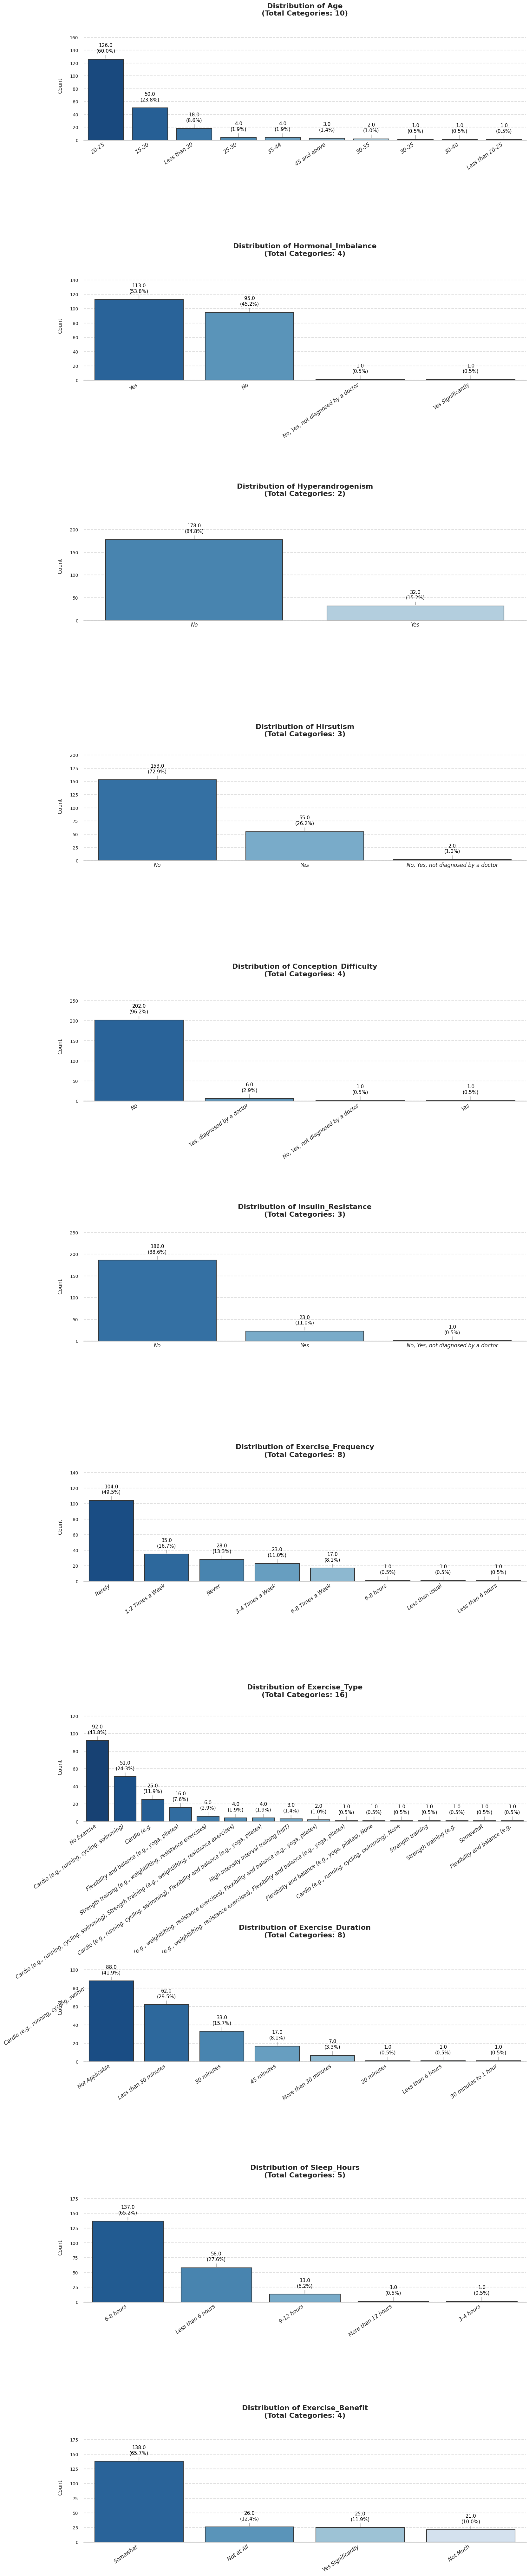

In [48]:
fig = plt.figure(figsize=(18, 8 * num_plots))  # More vertical space per plot
gs = fig.add_gridspec(num_plots, 1, hspace=1.2)  # Significant vertical gap between plots

axes = []
for idx in range(num_plots):
    axes.append(fig.add_subplot(gs[idx]))

# Create count plots with enhanced formatting
for idx, (col, ax) in enumerate(zip(categorical_cols, axes)):
    value_counts = train_df[col].value_counts().sort_values(ascending=False)
    total = len(train_df[col])

    # Create ordered bar plot with consistent coloring
    palette = sns.color_palette("Blues_r", n_colors=len(value_counts))
    plot = sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax,
                       palette=palette, edgecolor=".2", linewidth=1.5)

    # Title and subtitle formatting
    ax.set_title(f"Distribution of {col}\n(Total Categories: {len(value_counts)})",
                 fontsize=16, pad=35, weight='semibold')

    # X-axis formatting
    ax.set_xlabel("")
    ax.tick_params(axis='x', which='both', length=0)  # Remove tick marks
    if len(value_counts) > 3:
        plot.set_xticklabels(plot.get_xticklabels(),
                             rotation=35,
                             ha='right',
                             fontsize=12,
                             fontstyle='italic')
    else:
        plot.set_xticklabels(plot.get_xticklabels(),
                             fontsize=12,
                             fontstyle='italic')

    # Y-axis formatting
    ax.set_ylabel("Count", fontsize=12, labelpad=15)
    ax.set_ylim(0, value_counts.max() * 1.35)  # More space for annotations
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
    ax.tick_params(axis='y', labelsize=10)

    # Smart annotations with consistent positioning
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{height:,}\n({height / total:.1%})',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center',
                        xytext=(0, 25),  # Always place above bar
                        textcoords='offset points',
                        fontsize=11,
                        color='black',
                        linespacing=1.2,
                        arrowprops=dict(arrowstyle="-", color="black", alpha=0.3))

    # Clean axis borders and add custom grid
    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.grid(axis='y', color='lightgrey', linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)  # Ensure grid stays behind bars

# Final layout adjustments
plt.tight_layout(pad=8)  # Increased global padding
fig.subplots_adjust(top=0.95, bottom=0.05)  # Extra space at top and bottom
plt.show()

# Final layout adjustments

In [49]:
plt.tight_layout(pad=8)  # Increased global padding
fig.subplots_adjust(top=0.95, bottom=0.05)  # Extra space at top and bottom
plt.show()

<Figure size 640x480 with 0 Axes>

# Prepare Data for Model Building

# Select target and features

In [50]:
print("Columns in the dataset:", train_df.columns)

Columns in the dataset: Index(['ID', 'Age', 'Weight_kg', 'PCOS', 'Hormonal_Imbalance',
       'Hyperandrogenism', 'Hirsutism', 'Conception_Difficulty',
       'Insulin_Resistance', 'Exercise_Frequency', 'Exercise_Type',
       'Exercise_Duration', 'Sleep_Hours', 'Exercise_Benefit'],
      dtype='object')


# Based on the columns, set the target column (replace 'PCOS' with your actual target column)

In [51]:
target_column = 'PCOS'  # Update this with the correct target column name

X = train_df.drop(columns=[target_column])  # Features
y = train_df[target_column]  # Target

# Split into training and validation sets

In [52]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessing steps for numerical and categorical columns

In [53]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler())  # Feature scaling
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # OneHot Encoding
])

# Combine both transformations

In [54]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X.select_dtypes(include=[np.number]).columns.tolist()),
        ('cat', categorical_transformer, X.select_dtypes(include=['object', 'category']).columns.tolist())
    ])

# Model Development - Random Forest Classifier

# Define a pipeline with preprocessing and model

In [55]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model

In [56]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ID', 'Weight_kg']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Age', 'Hormonal_Imbalance',
                                                   'Hyperandrogenism',
                                                   'Hirsutism',
                                                   'Conception_Difficulty',
                                                   'Insulin_Resistance',
                                                   'Exercise_Frequency',
                                                   'Exercise_Type',
                                                   'Exercise_Duration',
                                                   'Sleep_Hours',
                                                   'Exercise_Benefit'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

# Make predictions on the validation set

In [57]:
y_pred = model_pipeline.predict(X_valid)
y_pred_proba = model_pipeline.predict_proba(X_valid)[:, 1]

# Evaluate model performance

In [58]:
print("Classification Report:")
print(classification_report(y_valid, y_pred))

print("\nROC-AUC Score:")
print(roc_auc_score(y_valid, y_pred_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.82        32
           1       0.38      0.30      0.33        10

    accuracy                           0.71        42
   macro avg       0.58      0.57      0.58        42
weighted avg       0.69      0.71      0.70        42


ROC-AUC Score:
0.7328125000000001


# Hyperparameter tuning for the Random Forest model

In [59]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ID',
                                                                          'Weight_kg']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Age',
                                                                          'Hormonal_Imbalance',
                                                                          '...
                                                                          'Hirsutism',
                                                                          'Conception_Difficulty',
                                                                          'Insulin_Resistance',
                                                                          'Exercise_Frequency',
                                                                          'Exercise_Type',
                                                                          'Exercise_Duration',
                                                                          'Sleep_Hours',
                                                                          'Exercise_Benefit'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 10, 20],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200]},
             verbose=1)

# Best parameters from Grid Search

In [60]:
print("\nBest Parameters from Grid Search:")
print(grid_search.best_params_)


Best Parameters from Grid Search:
{'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


# Evaluate the best model

In [61]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_valid)
y_pred_proba_best = best_model.predict_proba(X_valid)[:, 1]

print("\nBest Model Classification Report:")
print(classification_report(y_valid, y_pred_best))

print("\nBest Model ROC-AUC Score:")
print(roc_auc_score(y_valid, y_pred_proba_best))


Best Model Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        32
           1       0.44      0.40      0.42        10

    accuracy                           0.74        42
   macro avg       0.63      0.62      0.63        42
weighted avg       0.73      0.74      0.73        42


Best Model ROC-AUC Score:
0.75


# Save the best model using joblib for future use in the API

In [63]:
joblib.dump(best_model, 'models/pcos_model_new2.pkl')

['models/pcos_model_new2.pkl']